# Train 3D UNet on single molecule dataset; with deeper 3D Unet

## load data

In [1]:
import os 
import numpy as np
# from dataGenerator import imageLoader
# from dataGenerator import imageLoaderDeep
from dataGenerator import imageLoader3D
import keras
import matplotlib.pyplot as plt
import glob
import random

In [2]:
# visualize

def visusalizeIMG(n_slice, test_img, test_msk):
    # n_slice = random.randint(0, test_img.shape[2])
    plt.figure(figsize=(8, 8))

    plt.subplot(121)
    plt.imshow(test_img[n_slice,:,:], cmap='gray')
    # plt.title('focal slice')
    plt.subplot(122)
    plt.imshow(test_msk[n_slice,:,:], cmap='gray')
    # plt.titSle('GT slice')
    plt.show()

In [3]:
# generate the gif

import numpy as np
from PIL import Image
import SimpleITK as sitk
import mrcfile

def saveGIF(imageGIF, labelGIF, predict, direction, gif_directory):
    
    # print('during gif') 
    
    imageGIF = imageGIF  # the original dataset is 8 bits
    stack = []
    
    # print(image.shape, label.shape, predict.shape)
    # print('image:', np.max(imageGIF), np.min(imageGIF))
    # print('label after gif: ', np.max(labelGIF), np.min(labelGIF))
    # print('predict: ', np.max(predict), np.min(predict))
    
    bar = np.ones((imageGIF.shape[0], 10)) # divide the images
    
    if direction == 0:
        print('cut along x')
    elif direction == 1:
        print('cut along y')

    elif direction == 2:
        print('cut along z')
        
    else:
        print('please specify the direction')
    
    
    for i in range(imageGIF.shape[0]):

        if direction == 0:
            temp1 = imageGIF[i,...]
            temp2 = predict[i,...]
            temp3 = labelGIF[i,...]
            
        elif direction == 1:
            temp1 = imageGIF[:,i,:]
            temp2 = predict[:,i,:]
            temp3 = labelGIF[:,i,:]
        
        elif direction == 2:
            temp1 = imageGIF[...,i]
            temp2 = predict[...,i]
            temp3 = labelGIF[...,i]
        else:
            print('illegal cut')
        
        
        # print('round:', i)
        # print('image concatenate:', temp1.shape)
        # print('label concatenate:', temp2.shape)
        # print('predict concatenate:', temp3.shape)
        
        imageTemp = np.concatenate((temp1, bar, temp2, bar, temp3), axis=1)
        # print('after concatenate:', imageTemp.shape)
        stack.append(imageTemp)
        
    stack = np.asarray(stack)
    
    # imgs = [img*255 for img in stack]
    imgs = [Image.fromarray(img*255) for img in stack]  # pil要求整体图片乘上255
    # duration is the number of milliseconds between frames; this is 40 frames per second
    imgs[0].save(gif_directory, save_all=True, append_images=imgs[1:], duration=50, loop=0)
    
    # write as nii
    # writer = sitk.ImageFileWriter()
    # writer.SetFileName('./results/result.nii')
    # writer.Execute(stack)
    
    mrc = mrcfile.new('./results/result.mrc', overwrite=True)
    mrc.set_data((stack*255).astype('int8'))
    mrc.close
    
    np.save('./results/result.npy', stack)
    

In [4]:
# specify the dir

DATA_PATH = 'E:/EM/demo/3D_Unet_keras/data/2022_07/inputData/'

train_img_dir = DATA_PATH + 'train/images/'
train_msk_dir = DATA_PATH + 'train/masks/'

train_img_list = sorted(glob.glob(train_img_dir + '/*.npy'))
train_msk_list = sorted(glob.glob(train_msk_dir + '/*.npy'))

num_images = len(train_img_list)
print(num_images)

240


In [5]:
print('image list:', train_img_list[10])
print('mask list:', train_msk_list[10])

image list: E:/EM/demo/3D_Unet_keras/data/2022_07/inputData/train/images\image_110.npy
mask list: E:/EM/demo/3D_Unet_keras/data/2022_07/inputData/train/masks\mask_110.npy


In [6]:
# visualize the images

img_num = random.randint(0, num_images-1) # num从1开始
test_img = np.load(train_img_list[img_num])
test_img = test_img[...,0]
print('image shape:', test_img.shape)

test_mask = np.load(train_msk_list[img_num])
print('before mask:', test_mask.shape)
test_mask = np.argmax(test_mask, axis=3)
print('after mask:', test_mask.shape)

image shape: (64, 64, 64)
before mask: (64, 64, 64, 2)
after mask: (64, 64, 64)


In [7]:
#  reshape data for 2D deep UNet

# test = np.stack([test_mask], axis=3)
# print(test.shape)
test = np.expand_dims(test_mask, axis = -1)
print(test.shape)

(64, 64, 64, 1)


current slice: 32


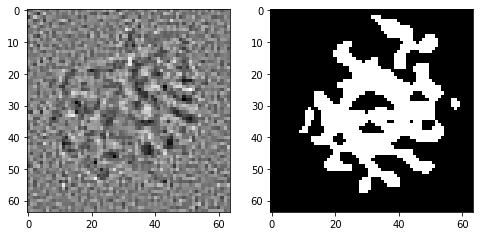

current slice: 34


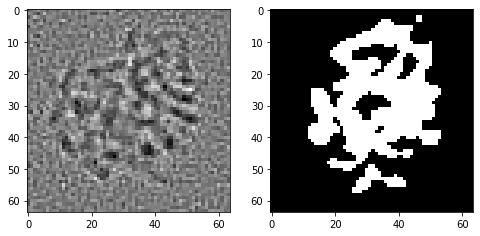

In [8]:
# visualize the images 

# n_slice = random.randint(0, test_mask.shape[2]-1)

n_slice = 32
print('current slice:', n_slice)
visusalizeIMG(n_slice, test_img, test_mask)

print('current slice:', n_slice + 2)
visusalizeIMG(n_slice + 2, test_img, test_mask)

### calculate the weight between labels. useful for weighted dice loss

In [9]:
import pandas as pd

columns = ['0', '1']
df = pd.DataFrame(columns=columns)

train_msk_list = sorted(glob.glob(train_msk_dir + '/*.npy'))

for img in range(len(train_msk_list)):
    
    # print(img)
    temp_image = np.load(train_msk_list[img])
    temp_image = np.argmax(temp_image, axis=3)  # convert back into images
    
    val, counts = np.unique(temp_image, return_counts=True) # count labels
    zipped = zip(columns, counts)
    counts_dict = dict(zipped)
    
    df = df.append(counts_dict, ignore_index = True)

In [10]:
# calculate the ratio of different labels

label_0 = df['0'].sum()
label_1 = df['1'].sum()

total_labels = label_0 + label_1
n_classes = 2

# class weight calculated: n_samples / (n_classes * n_samples_for_class)
wt0 = round((total_labels/(n_classes*label_0)), 2) # 小数点后两位
wt1 = round((total_labels/(n_classes*label_1)), 2)

print(wt0, wt1)

0.56 4.4


## Define the image generator

In [11]:
# data path and sort

from natsort import natsorted

DATA_PATH = 'E:/EM/demo/3D_Unet_keras/data/2022_08/inputData/'

train_img_dir = DATA_PATH + 'train/images/'
train_msk_dir = DATA_PATH + 'train/masks/'

train_img_list = natsorted(os.listdir(train_img_dir))
train_msk_list = natsorted(os.listdir(train_msk_dir))

# validation
val_img_dir = DATA_PATH + 'val/images/'
val_msk_dir = DATA_PATH + 'val/masks/'

val_img_list = natsorted(os.listdir(val_img_dir))
val_msk_list = natsorted(os.listdir(val_msk_dir))

# testing
test_img_dir = DATA_PATH + 'test/images/'
test_msk_dir = DATA_PATH + 'test/masks/'

test_img_list = natsorted(os.listdir(test_img_dir))
test_msk_list = natsorted(os.listdir(test_msk_dir))

print('train images:', len(train_img_list))
print('val images:', len(val_img_list))
print('test images:', len(test_img_list))

train images: 160
val images: 40
test images: 100


In [12]:
# data generator for training

batch_size = 2

train_img_datagen = imageLoader3D(train_img_dir, train_img_list,
                               train_msk_dir, train_msk_list, batch_size)

val_img_datagen = imageLoader3D(val_img_dir, val_img_list,
                             val_msk_dir, val_msk_list, batch_size)

image gen: (2, 64, 64, 64, 1)
mask gen: (2, 64, 64, 64, 1)
(64, 64, 64)
slice num: 16


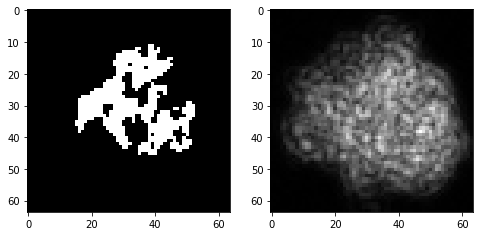

In [13]:
# visualize the data generator

img, msk = train_img_datagen.__next__()
print('image gen:', img.shape)
print('mask gen:', msk.shape)

stack_num = random.randint(0, img.shape[0]-1)
test_img = np.squeeze(img[stack_num,...])
test_mask = np.squeeze(msk[stack_num,...])
print(test_img.shape)

n_slice=random.randint(0, test_mask.shape[1]-1)
# n_slice = 50

print('slice num:', n_slice)
visusalizeIMG(n_slice, test_mask, test_img)

## Define the loss, metrics and optimizer for training

In [14]:
# wt0, wt1 = 0.5,0.5
wt0, wt1 = 0.56,4.4

import segmentation_models_3D as sm

dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1]))  # default is uniform
focal_loss = sm.losses.CategoricalFocalLoss()
BCE_loss = sm.losses.BinaryCELoss()

total_loss = dice_loss*0.005 + (1* focal_loss) + BCE_loss*1  # works for most segmentation jobs

# metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]  # metrics for final performance
metrics = [sm.metrics.IOUScore(threshold=0.5)]  # metrics for final performance
# metrics = ['accuracy', sm.metrics.FScore(beta=1)] # F1 score

LR = 0.0001
optim = keras.optimizers.Adam(LR)

Segmentation Models: using `tf.keras` framework.


In [15]:
# 调试用loss function

# loss function designed from scratch

# import tensorflow as tf
# import tensorflow.keras.backend as K

# LR = 0.0001
# optim = keras.optimizers.Adam(LR)


# # soft dice
# def dice_coef(y_true, y_pred, smooth=100):        
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
#     return dice


# def loss_function(y_true, y_pred):
#     dice_loss = -dice_coef(y_true, y_pred)
#     l1_loss = tf.math.reduce_mean(tf.math.abs(y_true - y_pred), axis=(1,2,3))  # tranfer matrix into value
#     SCE = tf.keras.metrics.binary_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=0.0, axis=-1)
    
#     # print('SCE shape:', SCE.shape)
    
#     # ssim_loss = tf.image.ssim_multiscale(y_true, y_pred, max_val=1)
    
#     total_loss = dice_loss*0.05 + l1_loss*0.5  + tf.math.reduce_mean(SCE, axis=(1,2))*1  #CE_loss #ssim_loss    # weight should be tuned SCE #
    
    
#     return total_loss

# jaccard_loss = JaccardLoss()
# dice_loss = DiceLoss()

# binary_focal_loss = BinaryFocalLoss()
# categorical_focal_loss = CategoricalFocalLoss()

# binary_crossentropy = BinaryCELoss()
# categorical_crossentropy = CategoricalCELoss()

# # loss combinations
# bce_dice_loss = binary_crossentropy + dice_loss
# bce_jaccard_loss = binary_crossentropy + jaccard_loss

# cce_dice_loss = categorical_crossentropy + dice_loss
# cce_jaccard_loss = categorical_crossentropy + jaccard_loss

# binary_focal_dice_loss = binary_focal_loss + dice_loss
# binary_focal_jaccard_loss = binary_focal_loss + jaccard_loss

# categorical_focal_dice_loss = categorical_focal_loss + dice_loss
# categorical_focal_jaccard_loss = categorical_focal_loss + jaccard_loss

## Fit the model

In [16]:
steps_per_epoch = len(train_img_list) // batch_size
val_steps_per_epoch = len(val_img_list) // batch_size

In [17]:
# load model from transfer learning

from model.simple3DUnet_512 import simple_unet_model

model = simple_unet_model(IMG_HEIGHT=64,
                         IMG_WIDTH=64,
                         IMG_DEPTH=64,
                         IMG_CHANNELS=1,
                         num_classes=1)   # change the num; 2->1. G.

model.compile(optimizer=optim, loss=total_loss, metrics=metrics)
# model.compile(optimizer=optim, loss=loss_function, metrics=[dice_coef]) 

# print(model.summary())
print(model.input_shape)
print(model.output_shape)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 64,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 64, 64, 64,   1312        ['input_1[0][0]']                
                                16)                                                               
                                                                                                  
 instance_normalization (Instan  (None, 64, 64, 64,   32         ['conv3d[0][0]']                 
 ceNormalization)               16)                                                           

## Train and save model

#### 测试batch 训练

2/2 [==============================] - 0s 27ms/step
0 [0.2155277132987976, 0.5687592029571533]


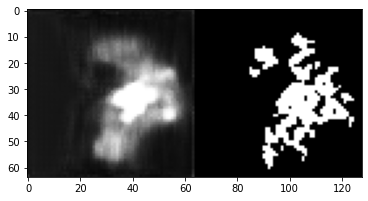

2/2 [==============================] - 0s 29ms/step
100 [0.1968788504600525, 0.6178313493728638]


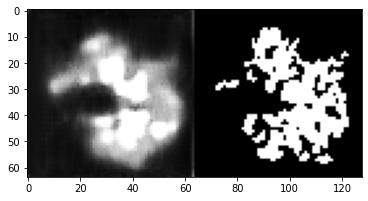

2/2 [==============================] - 0s 30ms/step
200 [0.1584334373474121, 0.6848232746124268]


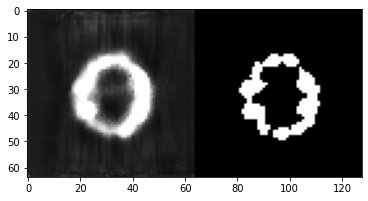

2/2 [==============================] - 0s 29ms/step
300 [0.13871930539608002, 0.7301411628723145]


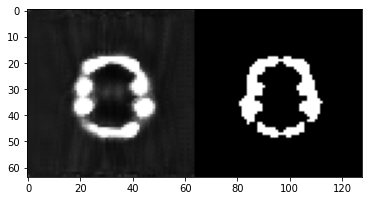

2/2 [==============================] - 0s 27ms/step
400 [0.17595656216144562, 0.6114534139633179]


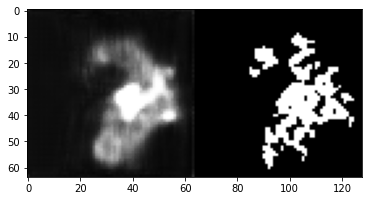

2/2 [==============================] - 0s 29ms/step
500 [0.1653793454170227, 0.6332876682281494]


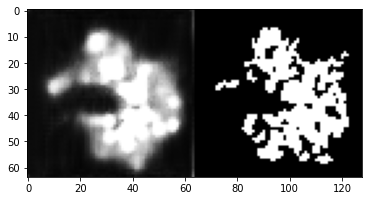

2/2 [==============================] - 0s 26ms/step
600 [0.12048974633216858, 0.7105497717857361]


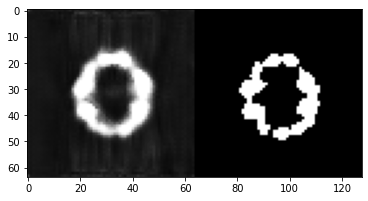

2/2 [==============================] - 0s 26ms/step
700 [0.10320881009101868, 0.7510480284690857]


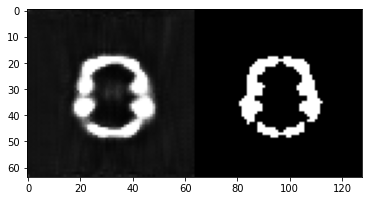

2/2 [==============================] - 0s 26ms/step
800 [0.15676333010196686, 0.6221633553504944]


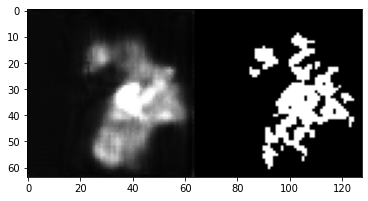

2/2 [==============================] - 0s 26ms/step
900 [0.1514367014169693, 0.6415196061134338]


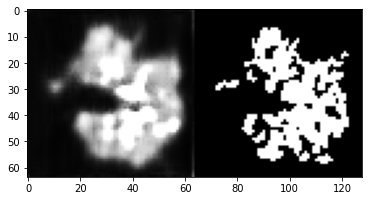

2/2 [==============================] - 0s 28ms/step
1000 [0.08995552361011505, 0.7247691750526428]


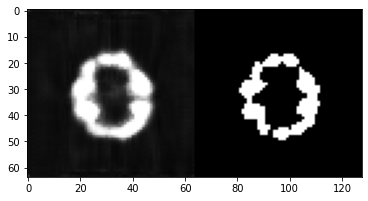

2/2 [==============================] - 0s 27ms/step
1100 [0.07811908423900604, 0.7774323225021362]


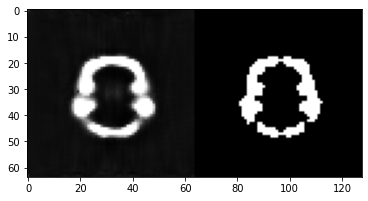

2/2 [==============================] - 0s 25ms/step
1200 [0.1379387080669403, 0.6377480626106262]


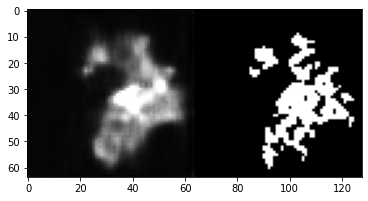

2/2 [==============================] - 0s 26ms/step
1300 [0.13364256918430328, 0.6547821164131165]


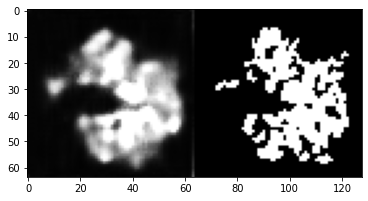

2/2 [==============================] - 0s 25ms/step
1400 [0.06625129282474518, 0.7865645885467529]


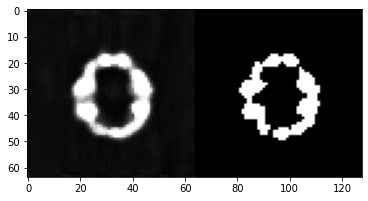

2/2 [==============================] - 0s 26ms/step
1500 [0.060882940888404846, 0.7871610522270203]


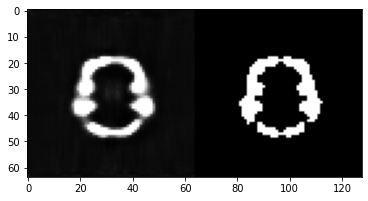

2/2 [==============================] - 0s 26ms/step
1600 [0.1293983906507492, 0.6415762305259705]


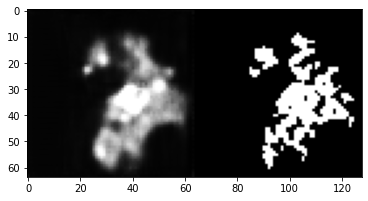

2/2 [==============================] - 0s 26ms/step
1700 [0.1280985325574875, 0.6588625311851501]


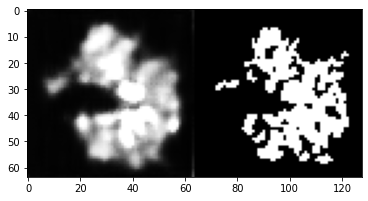

2/2 [==============================] - 0s 28ms/step
1800 [0.05500032752752304, 0.7795442938804626]


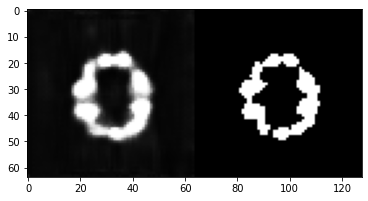

2/2 [==============================] - 0s 26ms/step
1900 [0.048739708960056305, 0.8044862747192383]


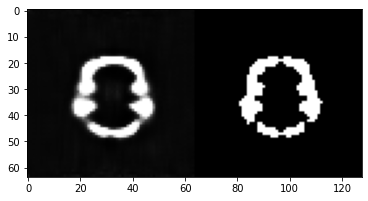

2/2 [==============================] - 0s 30ms/step
2000 [0.11605072766542435, 0.6725662350654602]


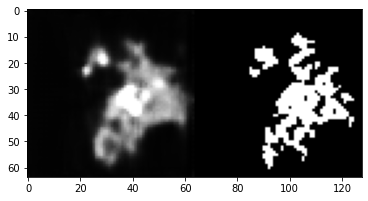

2/2 [==============================] - 0s 28ms/step
2100 [0.11117716878652573, 0.6864888668060303]


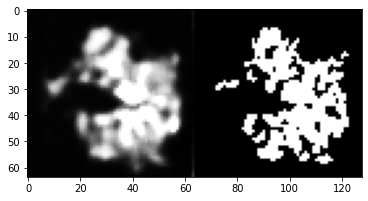

2/2 [==============================] - 0s 27ms/step
2200 [0.044089771807193756, 0.7874860763549805]


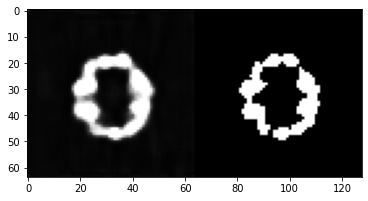

2/2 [==============================] - 0s 26ms/step
2300 [0.03888803347945213, 0.8138869404792786]


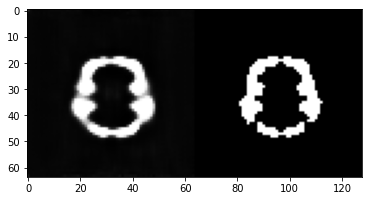

2/2 [==============================] - 0s 26ms/step
2400 [0.10882213711738586, 0.6923985481262207]


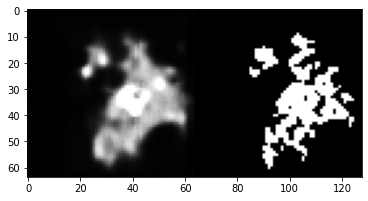

2/2 [==============================] - 0s 26ms/step
2500 [0.10775283724069595, 0.6874780654907227]


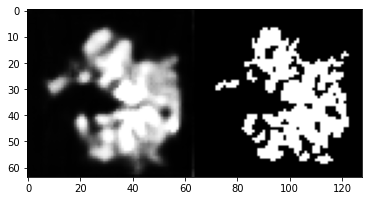

2/2 [==============================] - 0s 28ms/step
2600 [0.0387769415974617, 0.7863636612892151]


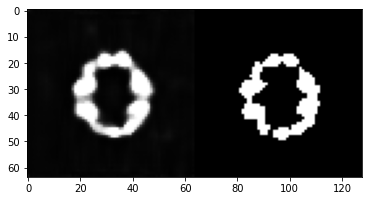

2/2 [==============================] - 0s 29ms/step
2700 [0.03595408797264099, 0.7896111607551575]


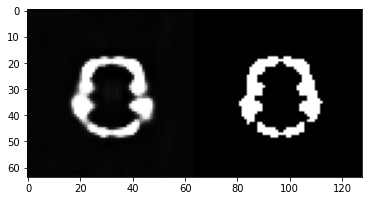

2/2 [==============================] - 0s 27ms/step
2800 [0.10331637412309647, 0.6972864270210266]


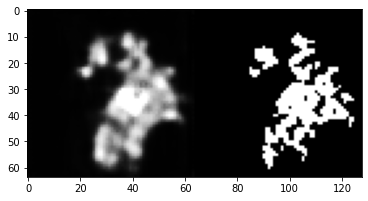

2/2 [==============================] - 0s 26ms/step
2900 [0.09956328570842743, 0.7104856967926025]


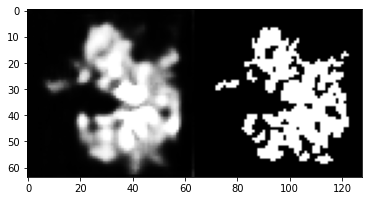

2/2 [==============================] - 0s 27ms/step
3000 [0.030679482966661453, 0.8116624355316162]


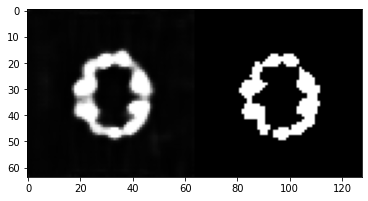

2/2 [==============================] - 0s 27ms/step
3100 [0.029155513271689415, 0.8105559945106506]


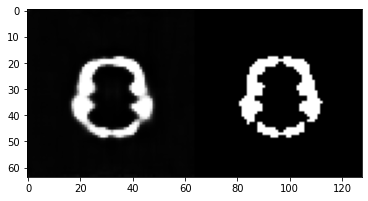

2/2 [==============================] - 0s 27ms/step
3200 [0.09852258861064911, 0.7069613337516785]


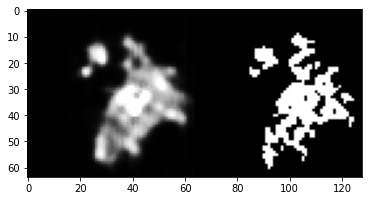

2/2 [==============================] - 0s 26ms/step
3300 [0.09399575740098953, 0.7102998495101929]


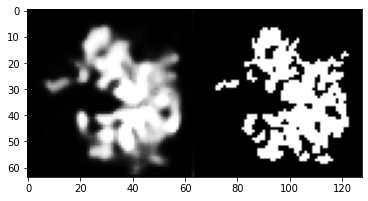

2/2 [==============================] - 0s 29ms/step
3400 [0.027460547164082527, 0.8021919131278992]


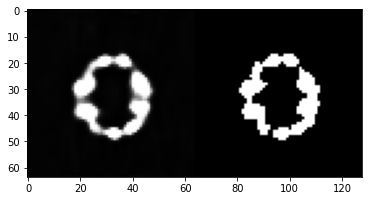

2/2 [==============================] - 0s 26ms/step
3500 [0.023561932146549225, 0.8300107717514038]


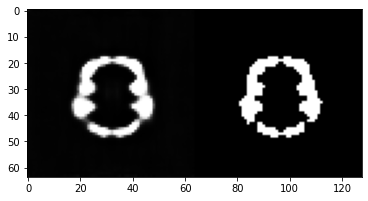

2/2 [==============================] - 0s 25ms/step
3600 [0.0924767330288887, 0.7197527289390564]


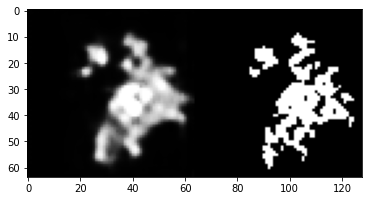

2/2 [==============================] - 0s 26ms/step
3700 [0.08733076602220535, 0.7307548522949219]


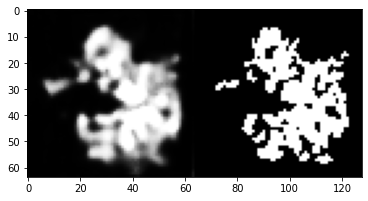

2/2 [==============================] - 0s 26ms/step
3800 [0.02121927961707115, 0.8319360017776489]


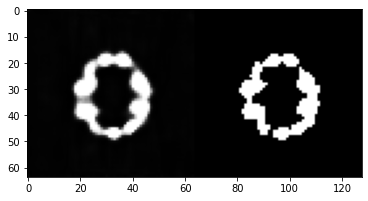

2/2 [==============================] - 0s 27ms/step
3900 [0.019827408716082573, 0.8411526679992676]


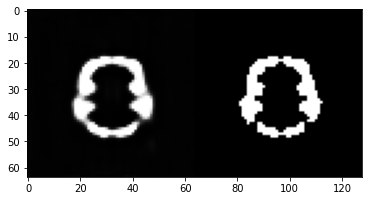

2/2 [==============================] - 0s 27ms/step
4000 [0.09132949262857437, 0.7206419706344604]


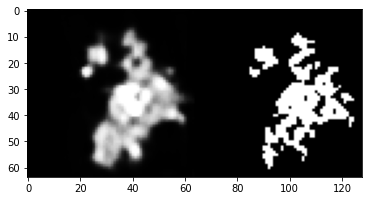

2/2 [==============================] - 0s 26ms/step
4100 [0.08606015145778656, 0.7317079901695251]


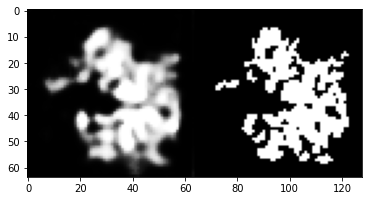

2/2 [==============================] - 0s 26ms/step
4200 [0.02012486569583416, 0.8209474086761475]


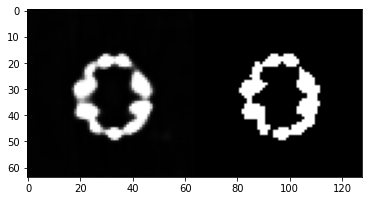

2/2 [==============================] - 0s 26ms/step
4300 [0.018769606947898865, 0.8339744210243225]


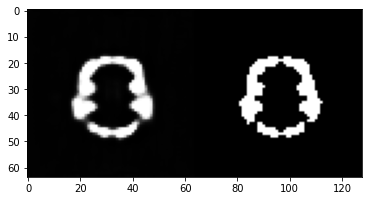

2/2 [==============================] - 0s 26ms/step
4400 [0.08678095042705536, 0.7243442535400391]


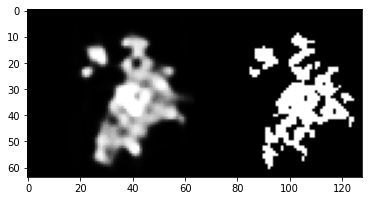

2/2 [==============================] - 0s 26ms/step
4500 [0.08073795586824417, 0.7454630136489868]


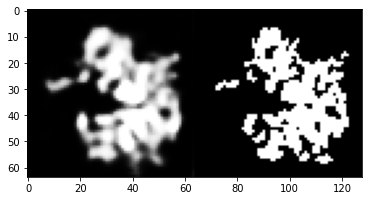

2/2 [==============================] - 0s 26ms/step
4600 [0.020499689504504204, 0.808179497718811]


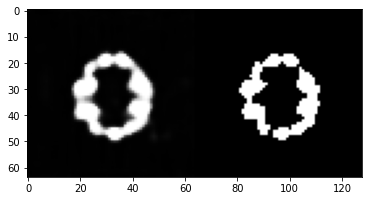

2/2 [==============================] - 0s 25ms/step
4700 [0.01551211066544056, 0.8472282886505127]


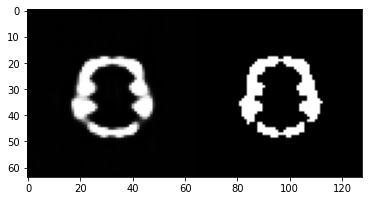

2/2 [==============================] - 0s 25ms/step
4800 [0.08142254501581192, 0.7417837381362915]


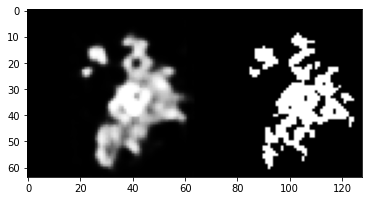

2/2 [==============================] - 0s 25ms/step
4900 [0.0795774757862091, 0.7451428174972534]


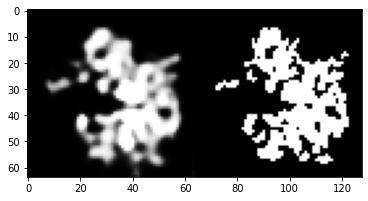

In [19]:
# 测试per batch
# train_on_batch

NUM_STEPS = 5000

# model.summary()

for step in range(NUM_STEPS):
    
    img, msk = train_img_datagen.__next__()
    # msk = np.argmax(msk, axis=-1).astype('float64') 
    # msk = np.expand_dims(msk, axis=4) # keep the shape [None, W, H, D, CH=1]
    
    # img = np.squeeze(img)
    # msk = np.argmax(msk, axis=-1).astype('float64')  # remove last channel
    # msk = np.expand_dims(mBCE_lossaxis=-1).astype('float64')
    
    loss = model.train_on_batch(img, msk)  # control the way to consume MM
    
    # print(step, loss)
    
    # if step % 1000 == 0:
    #     # model.save_weights('./modelDeep_loss.hdf5')
    #     model.save('./weight/modelDeep_3D_512_batch1.hdf5')  # directly save the whole model
        
    if step % 100 == 0:
        prediction = model.predict(img,batch_size=1)
        # print(prediction.shape, msk.shape)
        # print(prediction[0,:,32,:,:].shape, msk[0,:,32,:].shape)
        print(step, loss)
        plt.imshow(np.concatenate((np.squeeze(prediction[0,:,32,:,:]), np.squeeze( msk[0,:,32,:,:])), axis=1),cmap='gray')
        plt.show()
        plt.close('all')


In [ ]:
# visualize of last training images

showPred = prediction
showMask = msk
showIMG = img
print(showPred.shape, showMask.shape)
n_slice = random.randint(0, showPred.shape[1])

NUM = 0
print('slice Num:', n_slice)
visusalizeIMG(n_slice, showPred[NUM,...], showMask[NUM,...])

In [ ]:
# generate one gif of the stack

NUM = 0
direction = 0
gif_directory = './results/result.gif'

saveGIF(showIMG[NUM,...].squeeze(), showMask[NUM,...].squeeze(), showPred[NUM,...].squeeze(), direction, gif_directory)


#### Train in fit

In [18]:
import tensorflow.keras as k

callbacks = [
    k.callbacks.EarlyStopping(patience=15, monitor='val_loss'),
    k.callbacks.TensorBoard(log_dir = './tensorBoard/3D/512/')]

In [19]:

# original model
EPOCHS = 50

history = model.fit(train_img_datagen,
                   steps_per_epoch=steps_per_epoch,
                   epochs=EPOCHS,
                   verbose=1, # ??
                   validation_data=val_img_datagen,
                   validation_steps=val_steps_per_epoch, callbacks=callbacks)


MODEL_PATH = 'E:/EM/demo/3D_Unet_keras/weight/'

model.save(MODEL_PATH + 'deep_3d_512' + '_202208_' + str(EPOCHS) + '.hdf5')

Epoch 1/50
80/80 [==============================] - 31s 216ms/step - loss: 0.6834 - iou_score: 0.1687 - val_loss: 0.6281 - val_iou_score: 0.2389
Epoch 2/50
80/80 [==============================] - 17s 207ms/step - loss: 0.6091 - iou_score: 0.2954 - val_loss: 0.5974 - val_iou_score: 0.3386
Epoch 3/50
80/80 [==============================] - 17s 209ms/step - loss: 0.5838 - iou_score: 0.3625 - val_loss: 0.5760 - val_iou_score: 0.3898
Epoch 4/50
80/80 [==============================] - 16s 206ms/step - loss: 0.5623 - iou_score: 0.4018 - val_loss: 0.5559 - val_iou_score: 0.4276
Epoch 5/50
80/80 [==============================] - 17s 207ms/step - loss: 0.5369 - iou_score: 0.4353 - val_loss: 0.5335 - val_iou_score: 0.4572
Epoch 6/50
80/80 [==============================] - 17s 208ms/step - loss: 0.5134 - iou_score: 0.4615 - val_loss: 0.5115 - val_iou_score: 0.4810
Epoch 7/50
80/80 [==============================] - 17s 209ms/step - loss: 0.4886 - iou_score: 0.4856 - val_loss: 0.4937 - val_iou

## Visualize the training process

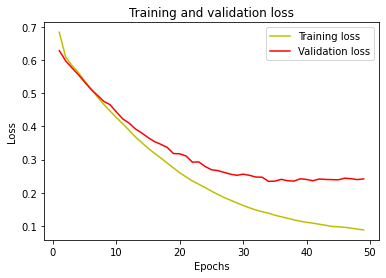

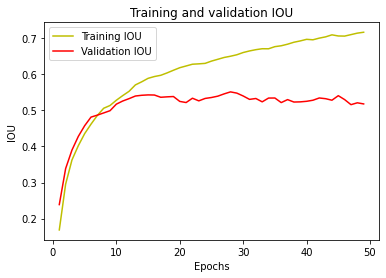

In [20]:

FIG_PATH = './reports/'

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(FIG_PATH + 'loss_3D_512_2022_08.png', dpi=300, bbox_inches = 'tight')
plt.show()


# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# plt.plot(epochs, acc, 'y', label='Training accuracy')
# plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# IoU
IoU = history.history['iou_score']
val_iou = history.history['val_iou_score']
plt.figure()
plt.plot(epochs, IoU, 'y', label='Training IOU')
plt.plot(epochs, val_iou, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.savefig(FIG_PATH + 'IoU_3D_512_2022_08.png', dpi=300, bbox_inches = 'tight')
plt.show()

## Predict the test dataset of single image

In [21]:
# load in the model

from keras.models import load_model

MODEL_PATH = 'E:/EM/demo/3D_Unet_keras/weight/'

my_model = load_model(MODEL_PATH + 'deep_3d_512' + '_' + str(EPOCHS) + '.hdf5', compile=False)
# my_model = load_model('./weight/deep_3D_512_50.hdf5', compile=False)

In [22]:
# for prediction verify IoU

from keras.metrics import MeanIoU

batch_size = 4  # prediction batch

test_img_datagen = imageLoader3D(test_img_dir, test_img_list,
                              test_msk_dir, test_msk_list, batch_size)

In [23]:
# verify the generator

test_image_batch, test_mask_batch = test_img_datagen.__next__()  
print('before:', test_mask_batch.shape)
# test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4) # convert onehot back to integer
# print('after:', test_mask_batch_argmax.shape)

before: (4, 64, 64, 64, 1)


In [24]:
# predict

test_pred_batch = my_model.predict(test_image_batch)
print(test_pred_batch.shape)
test_pred_batch = np.expand_dims(np.squeeze(test_pred_batch), axis=4)
print(test_pred_batch.shape, test_mask_batch.shape)

1/1 [==============================] - 1s 1s/step
(4, 64, 64, 64, 1)
(4, 64, 64, 64, 1) (4, 64, 64, 64, 1)


In [25]:
# n_classes = 2

n_classesG = 2
IOU_keras = MeanIoU(num_classes=n_classesG)  
IOU_keras.update_state(np.squeeze(test_pred_batch), np.squeeze(test_mask_batch))
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.48403126


## Predict the test dataset of multiple image

In [26]:
img_num = 15  # the name in test dataset

test_img = np.load(DATA_PATH + '/test/images/image_'+str(img_num)+'.npy')

test_mask = np.load(DATA_PATH + '/test/masks/mask_'+str(img_num)+'.npy')
# print(test_img.shape, test_mask.shape)
test_mask_argmax = np.argmax(test_mask, axis=3)
# test_mask_argmax = np.expand_dims(test_mask_argmax, axis=3)
print(test_img.shape, test_mask_argmax.shape)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction = np.squeeze(test_prediction[0,...])
print(test_prediction.shape)

(64, 64, 64, 1) (64, 64, 64)
1/1 [==============================] - 1s 643ms/step
(64, 64, 64)


current slice: 35


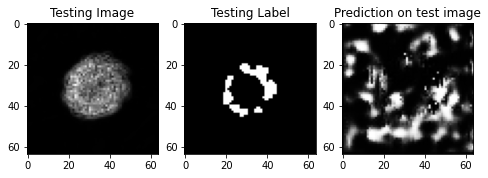

In [51]:
# visualize in x direction

n_slice = random.randint(0, test_prediction.shape[0]-1)

print('current slice:', n_slice)
plt.figure(figsize=(8, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[n_slice,:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[n_slice,:,:], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction[n_slice,:,:], cmap='gray')
plt.show()

current slice: 40


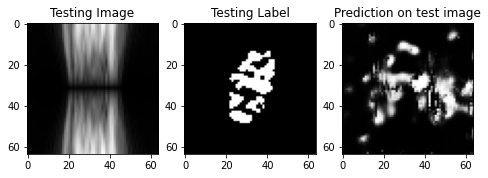

In [56]:
# visualize in y direction

n_slice = random.randint(0, test_prediction.shape[0]-1)

print('current slice:', n_slice)

plt.figure(figsize=(8, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,n_slice,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,n_slice,:], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction[:,n_slice,:], cmap='gray')
plt.show()